In [1]:
run '../__init__.py'

In [2]:
import numpy as np
import networkx as nx
import osmnx as ox
import contextily
import shapely

import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

import scipy.io as sio
from sodapy import Socrata

import plotly.graph_objects as go

In [3]:
APP_TOKEN = os.getenv("APP_TOKEN")
client = Socrata("data.cityofnewyork.us", APP_TOKEN, timeout=3600)

# Chelsea: Mapping ATRs onto OSMNX

## OSMNX

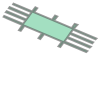

In [4]:
polygon = gpd.read_file("chelsea_network.geojson")
polygon = polygon.to_crs(4326)
polygon = polygon.iat[0, 0]
polygon

In [5]:
# create network from that polygon
G = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

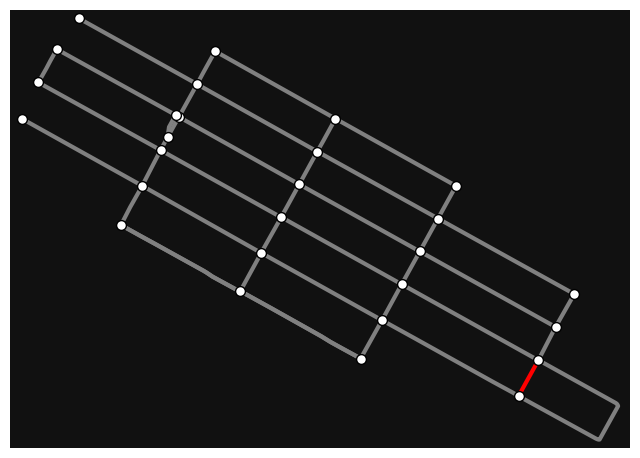

In [6]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [7]:
# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Filter edges to ensure that they're all contained within the defined polygon
gdf_edges = gdf_edges[gdf_edges.geometry.within(polygon) == True]

# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

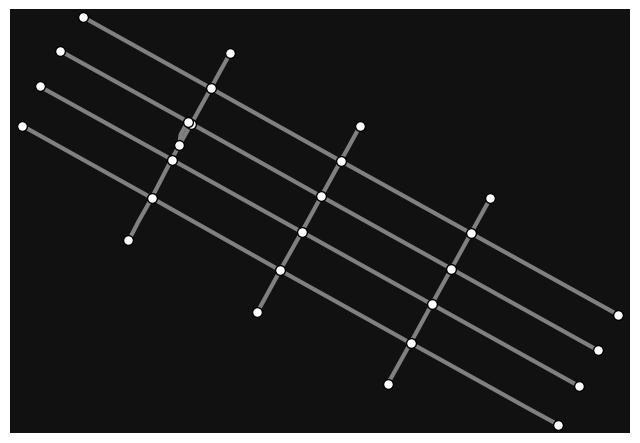

In [8]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

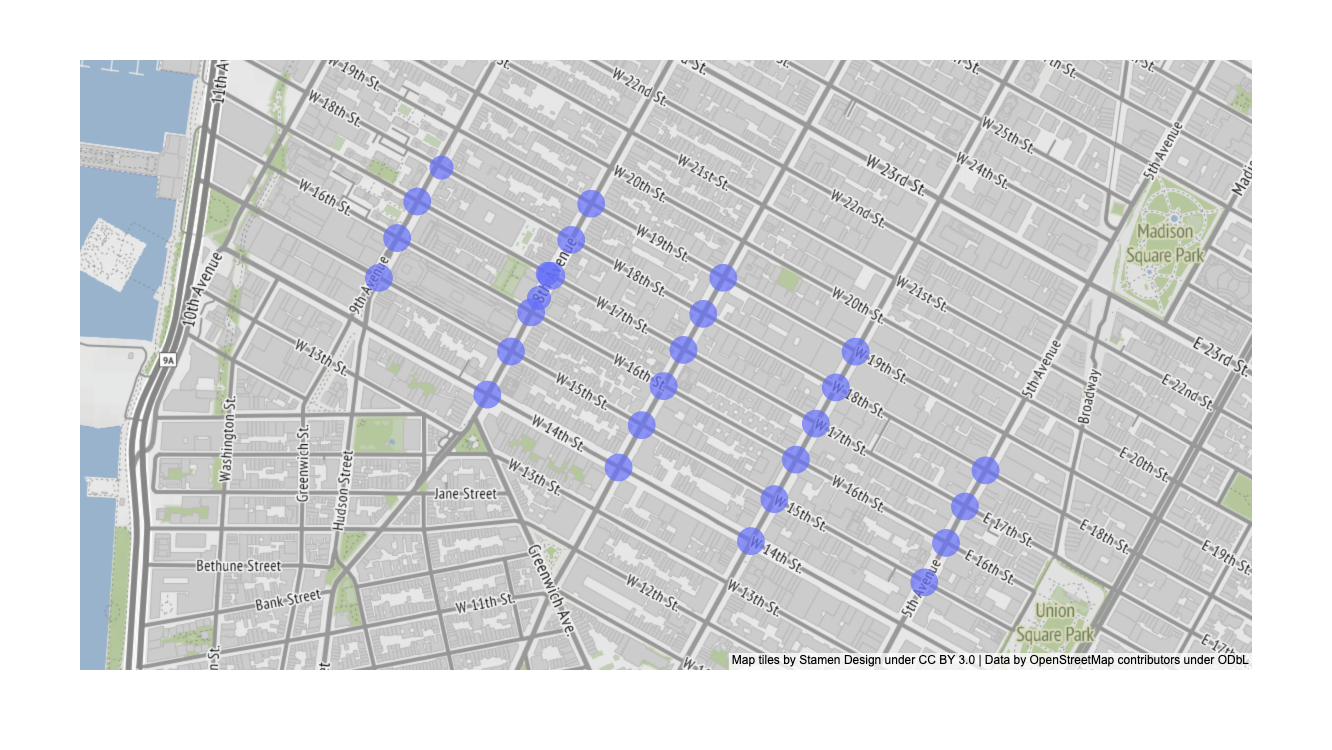

In [9]:
fig = px.scatter_mapbox(gdf_nodes,
                        size='street_count',
                        lat=gdf_nodes.geometry.y,
                        lon=gdf_nodes.geometry.x,
                        hover_name="highway",
                        mapbox_style="stamen-terrain",
                        width=1000, height=750,
                        zoom=15)
fig

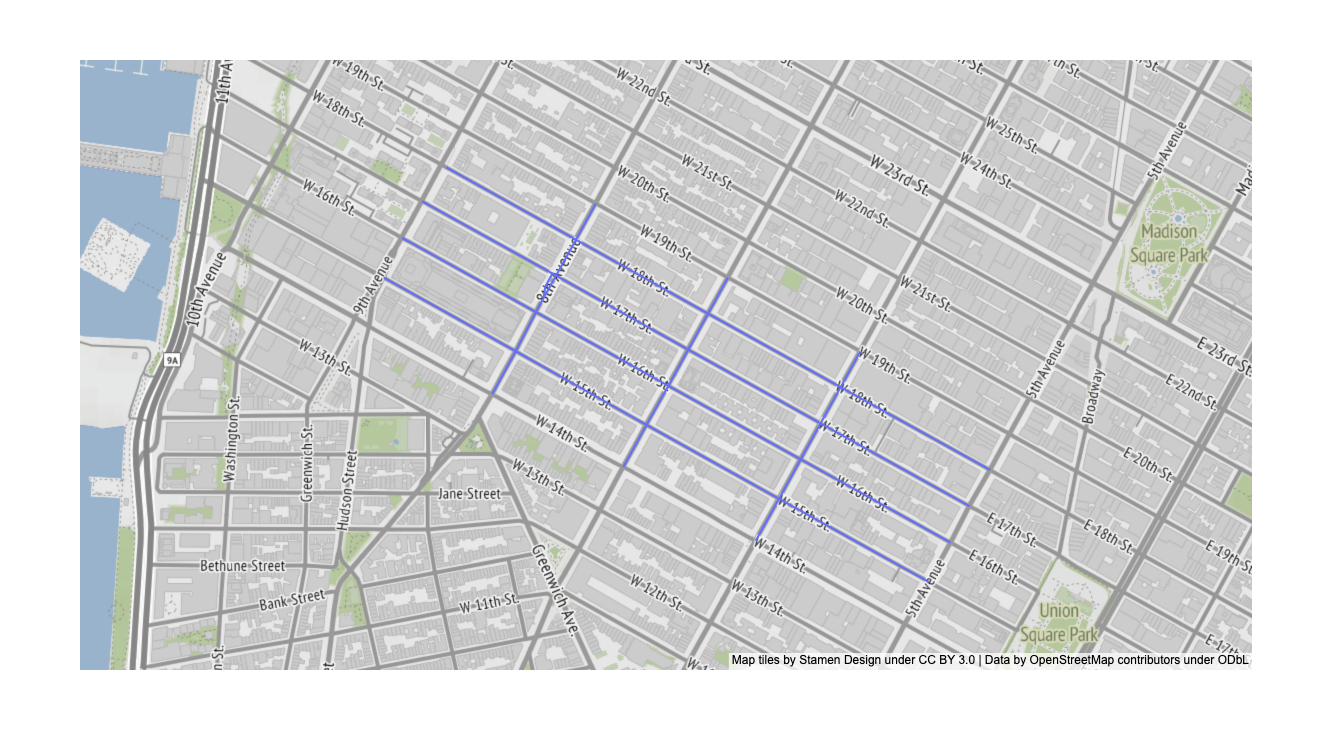

In [10]:
lats = []
lons = []
names = []

for feature, name in zip(gdf_edges.geometry, gdf_edges.name):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)

fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names, width=1000, height=750,
                     mapbox_style="stamen-terrain", zoom=15)
fig.show()


In [11]:
# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.get_digraph(G, weight='travel_time')

## ATRs

In [12]:
endpoint = "7ym2-wayt"

query = "SELECT COUNT(*)"
NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
NUM_RECORDS

27414481

In [13]:
def request_atr_series(ids):
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    # query = f"""
    #     SELECT *
    #     WHERE segmentid IN ({', '.join(map(str, ids))})
    #     LIMIT {NUM_RECORDS}
    # """    
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

In [14]:
def clean_atr(df, outflows, dt_range=('2019-06-05', '2019-06-07')):
    
    # Data Cleaning
    df = df[['segment_direction', 'geometry', 'boro', 'street', 'fromst', 'tost', 'direction', 'ts', 'vol']]
    
    if dt_range:
        df = df[df.ts.between(*dt_range)]
    
    # Mark flow types as infow or outflow
    df['flow_type'] = 'inflow'
    df.loc[df.segment_direction.isin(outflows), 'flow_type'] = 'outflow'
    # Set outflows as negative volumes
    df['flow'] = df.vol.copy()
    df.loc[df.flow_type=='outflow', 'flow'] *= -1
    
    return df

<Axes: >

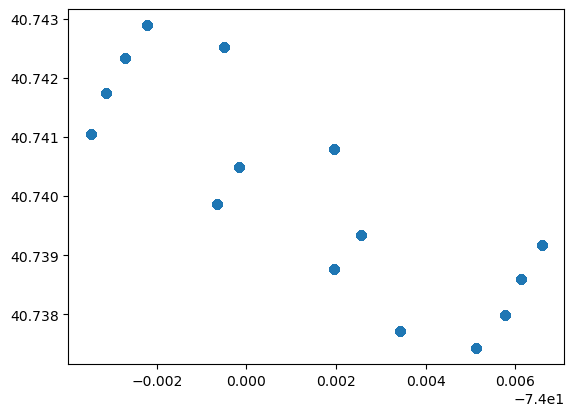

In [15]:
df = request_atr_series([32462, 32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])
df.plot()

## Matching

In [16]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
df_mapped = df.to_crs(3857).sjoin_nearest(gdf_edges.to_crs(3857))

In [17]:
df_mapped.groupby(['street', 'fromst', 'tost', 'name']).size()

street                  fromst                   tost                     name            
7 AVENUE                Broadway/ 7 Avenue Line  Broadway/ 7 Avenue Line  7th Avenue          1176
8 AVENUE                8 Avenue Line            8 Avenue Line            8th Avenue           868
AVENUE OF THE AMERICAS  14 Street/canarsie Line  6 Avenue Line            6th Avenue          1065
WEST 15 STREET          5 Avenue                 6 Avenue Line            West 15th Street    1160
                        6 Avenue Line            7 Avenue                 West 15th Street    1156
                        7 Avenue                 8 Avenue                 West 15th Street    1155
                        8 Avenue                 9 Avenue                 West 15th Street    1162
WEST 16 STREET          5 Avenue                 6 Avenue Line            West 16th Street    1058
                        6 Avenue Line            7 Avenue                 West 16th Street    1058
                  

In [18]:
df_mapped.head()

requestid       boro    yr   m   d  hh  mm   vol segmentid          street  \
0     32318  Manhattan  2019  10  18  17   0   0.0     32299  WEST 16 STREET   
1     32318  Manhattan  2019  10  18  17  15  58.0     32299  WEST 16 STREET   
2     32318  Manhattan  2019  10  18  17  30  72.0     32299  WEST 16 STREET   
3     32318  Manhattan  2019  10  18  17  45  73.0     32299  WEST 16 STREET   
6     32318  Manhattan  2019  10  18  18   0  79.0     32299  WEST 16 STREET   

     fromst      tost direction                  ts  \
0  8 Avenue  9 Avenue        EB 2019-10-18 17:00:00   
1  8 Avenue  9 Avenue        EB 2019-10-18 17:15:00   
2  8 Avenue  9 Avenue        EB 2019-10-18 17:30:00   
3  8 Avenue  9 Avenue        EB 2019-10-18 17:45:00   
6  8 Avenue  9 Avenue        EB 2019-10-18 18:00:00   

                           geometry segment_direction  index_right0  \
0  POINT (-8237992.445 4974324.002)          32299-EB      42444909   
1  POINT (-8237992.445 4974324.002)          32299-EB      42444909   
2  POINT (-8237992.445 4974324.002)          32299-EB      42444909   
3  POINT (-8237992.445 4974324.002)          32299-EB      42444909   
6  POINT (-8237992.445 4974324.002)          32299-EB      42444909   

   index_right1  index_right2      osmid  oneway lanes              name  \
0      42435599             0  348477348    True   NaN  West 16th Street   
1      42435599             0  348477348    True   NaN  West 16th Street   
2      42435599             0  348477348    True   NaN  West 16th Street   
3      42435599             0  348477348    True   NaN  West 16th Street   
6      42435599             0  348477348    True   NaN  West 16th Street   

       highway maxspeed  reversed   length  speed_kph  travel_time  
0  residential   25 mph     False  277.178       40.2         24.8  
1  residential   25 mph     False  277.178       40.2         24.8  
2  residential   25 mph     False  277.178       40.2         24.8  
3  residential   25 mph     False  277.178       40.2         24.8  
6  residential   25 mph     False  277.178       40.2         24.8

## Misc

In [19]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

396325.23819887225

In [20]:
# show some basic stats about the network
ox.basic_stats(G, area=graph_area_m, clean_int_tol=15)

/Users/kimsha/anaconda3/envs/spec/lib/python3.10/site-packages/osmnx/simplification.py:462: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/Users/kimsha/anaconda3/envs/spec/lib/python3.10/site-packages/osmnx/simplification.py:441: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




{'n': 28,
 'm': 34,
 'k_avg': 2.4285714285714284,
 'edge_length_total': 5746.409999999999,
 'edge_length_avg': 169.01205882352937,
 'streets_per_node_avg': 3.892857142857143,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 0, 3: 3, 4: 25},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.10714285714285714,
  4: 0.8928571428571429},
 'intersection_count': 28,
 'street_length_total': 5746.41,
 'street_segment_count': 34,
 'street_length_avg': 169.0120588235294,
 'circuity_avg': 1.000141650057577,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 1,
 'node_density_km': 70.64904603917722,
 'intersection_density_km': 70.64904603917722,
 'edge_density_km': 14499.228023213867,
 'street_density_km': 14499.22802321387,
 'clean_intersection_density_km': 2.5231802156849006}

In [21]:
nx.laplacian_matrix(G.to_undirected())
nx.directed_laplacian_matrix(D).shape

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning:

laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

<class 'networkx.utils.decorators.argmap'> compilation 21:5: FutureWarning:

directed_laplacian_matrix will return a numpy array instead of a matrix in NetworkX 3.0



(28, 28)